# League of Legends Machine Learning

Load libraries and API key

In [2]:
import requests, json
import numpy as np
from src import feature_calc
from src import API_io
import importlib
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import src.plotting as lol_plt
%matplotlib inline
import pdb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [4]:
#working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\lolML'
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

In [5]:
os.chdir(working_dir)
with open('EUW combined_df.pickle', 'rb') as pickle_file:
    euw_timelines_df = pickle.load(pickle_file)
with open('KR combined_df.pickle', 'rb') as pickle_file:
    kr_timelines_df = pickle.load(pickle_file)
with open('NA combined_df.pickle', 'rb') as pickle_file:
    na_timelines_df = pickle.load(pickle_file)

In [6]:
euw_timelines_df = [feature_calc.calc_secondary_features(x) for x in euw_timelines_df]
na_timelines_df = [feature_calc.calc_secondary_features(x) for x in na_timelines_df]
kr_timelines_df = [feature_calc.calc_secondary_features(x) for x in kr_timelines_df]
euw_timelines_df = feature_calc.calc_second_diff(euw_timelines_df)
na_timelines_df = feature_calc.calc_second_diff(na_timelines_df)
kr_timelines_df = feature_calc.calc_second_diff(kr_timelines_df)

In [7]:
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)

In [8]:
import matplotlib as mpl
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=2)

## Naive Bayes: - return to this

First let's see how good prediction is with each feature individually

In [ ]:
gnb = GaussianNB()
def quick_score(games_df, col_index):
    gnb.fit(games_df[[col_index]], games_df['winner'])
    return gnb.score(games_df[[col_index]], games_df['winner'])

[quick_score(games_df, x) for x in np.arange(num_features-1)]

First dragon and first tower are both pretty meaningful, but first blood isn't. The most important thing, though, is gold.

Now let's use machine learning to look at everything together. Let's do a 10-fold cross-validation on the data, and see what the average score is.

In [ ]:
scores = cross_validation.cross_val_score(gnb, games_df[train_col], games_df['winner'], cv=10)
print(np.mean(scores))

The full predictor is not that much more informative than the individual parameters! What if we try a:

## SVC Feature importance - return to this

Some sample code using built in recursive feature elimination and cross-validation. I never waited long enough for this to finish!

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=3,
              scoring='accuracy')

In [ ]:
# this takes a long time to run
rfecv.fit(timelines_df[-1][train_col], timelines_df[-1]['winner'])

## Random Forest Feature Importance

Start with a large random forest to get a sense of which features are important at different timepoints. First, let's get a dataframe for each timepoint

In [64]:
default_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 25, max_features = 'sqrt')
better_forest =  RandomForestClassifier(n_jobs = 2, n_estimators = 25, max_features = 'sqrt', min_samples_leaf=10, min_samples_split=25)

In [14]:
col_names = na_timelines_df[0].columns
train_col = np.array([x for x in col_names if x not in
             ['winner', 'game_length', 'blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4',
              'red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'matchId', 'utctimestamp'] ])
num_features = np.size(train_col)
print(train_col, )

['first_dragon' 'drag_diff' 'total_drag' 'first_baron' 'blue_barons'
 'red_barons' 'first_tower' 'tower_diff' 'total_tower' 'first_inhib'
 'blue_inhibs' 'red_inhibs' 'first_blood' 'gold_diff' 'kill_diff'
 'total_kill' 'blue_share' 'red_share' 'surrender' 'square_gold_diff']


In [68]:
default_importances  = np.zeros([len(na_timelines_df), np.size(train_col)])
better_importances  = np.zeros([len(na_timelines_df), np.size(train_col)])
for i, cur_df in enumerate(na_timelines_df):
    default_forest.fit(cur_df[train_col], cur_df['winner'])
    better_forest.fit(cur_df[train_col], cur_df['winner'])
    
    default_importances[i] = default_forest.feature_importances_
    better_importances[i] = better_forest.feature_importances_

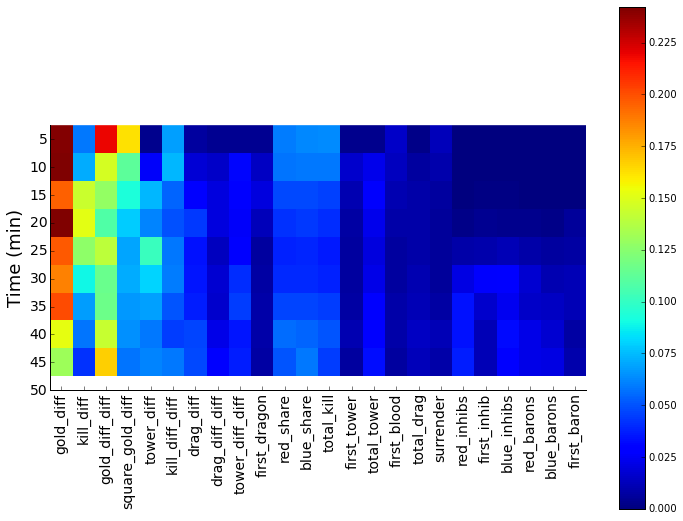

In [76]:
default_indices_20 = np.argsort(default_importances[3])[::-1]
default_indices_35 = np.argsort(default_importances[6])[::-1]
feature_fig = plt.figure(figsize = [12,9])
plt.imshow(default_importances[1:,indices_at_20], interpolation = 'none', extent = [0, num_features*4, 47.5, 2.5])
plt.ylabel('Time (min)', fontsize = 18)
plt.xticks(np.arange(0, num_features*4, 4)+2, indices_at_20)
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
lol_plt.prettify_axes(plt.gca())
plt.gca().yaxis.set_ticks(time_indices);
plt.colorbar();

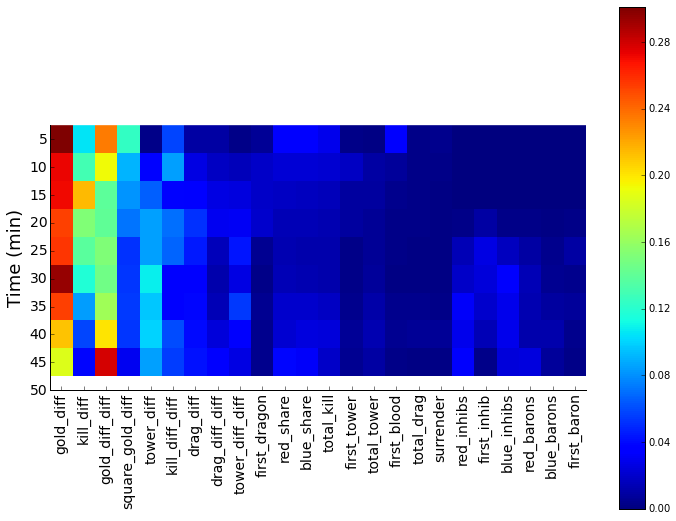

In [77]:
better_indices_20 = np.argsort(better_importances[3])[::-1]
better_indices_35 = np.argsort(better_importances[6])[::-1]
feature_fig = plt.figure(figsize = [12,9])
plt.imshow(better_importances[1:,indices_at_20], interpolation = 'none', extent = [0, num_features*4, 47.5, 2.5])
plt.ylabel('Time (min)', fontsize = 18)
plt.xticks(np.arange(0, num_features*4, 4)+2, indices_at_20)
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
lol_plt.prettify_axes(plt.gca())
plt.gca().yaxis.set_ticks(time_indices);
plt.colorbar();

Gold differential is the most important feature at all timepoints, followed by kill differential, and tower differential. Dragon differential comes in late, behind the total number of towers, at #6. Barons and inhibitors are not particularly informative at later timepoints, probably because they are a reflection of gold and kill differentials.

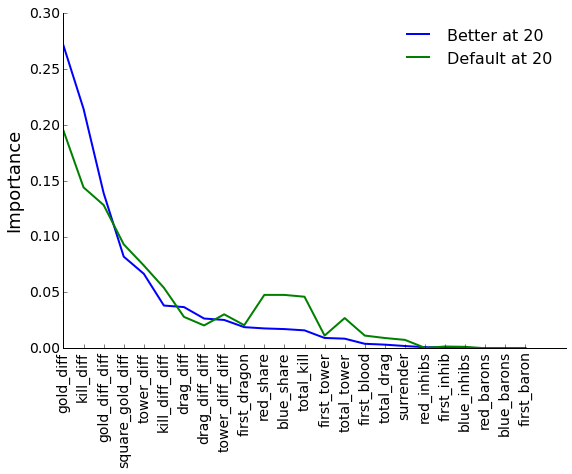

In [75]:
better_indices_20 = np.argsort(better_importances[3])[::-1]
default_indices_20 = np.argsort(default_importances[3])[::-1]
plt.figure(figsize = [9, 6])
plt.plot(better_importances[3,indices_at_20], label = 'Better at 20', linewidth = 2)
plt.plot(default_importances[3,indices_at_20], label = 'Default at 20', linewidth = 2)
plt.ylabel('Importance', fontsize = 18)
plt.xticks(np.arange(num_features))
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.legend(frameon = False, fontsize = 16)
lol_plt.prettify_axes(plt.gca())

Let's extract the important columns for future analyses

In [92]:
import_at_20 = train_col[better_indices_20[:7]]
import_at_35 = train_col[better_indices_35[:10]]
better_col = np.unique(np.append(import_at_20, import_at_35))
print(better_col)

['blue_inhibs' 'drag_diff' 'first_inhib' 'gold_diff' 'gold_diff_diff'
 'kill_diff' 'kill_diff_diff' 'square_gold_diff' 'tower_diff'
 'tower_diff_diff']


In [86]:
train_col[better_indices_35]

array(['gold_diff', 'gold_diff_diff', 'kill_diff', 'tower_diff',
       'square_gold_diff', 'kill_diff_diff', 'blue_inhibs', 'drag_diff',
       'tower_diff_diff', 'first_inhib', 'red_inhibs', 'red_share',
       'red_barons', 'blue_share', 'total_kill', 'drag_diff_diff',
       'total_tower', 'blue_barons', 'first_baron', 'first_dragon',
       'first_tower', 'first_blood', 'total_drag', 'surrender'], 
      dtype='<U16')

In [91]:
import_at_20 = train_col[default_indices_20[:7]]
import_at_35 = train_col[default_indices_35[:10]]
default_col = np.unique(np.append(import_at_20, import_at_35))
print(default_col)

['blue_share' 'gold_diff' 'gold_diff_diff' 'kill_diff' 'kill_diff_diff'
 'red_share' 'square_gold_diff' 'total_kill' 'tower_diff' 'tower_diff_diff']


# Dimensionality reduction - PCA

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=6)

In [31]:
scalar_col = np.array([x for x in important_col if x[0] != 'f'])
scalar_col

array(['blue_inhibs', 'blue_barons', 'drag_diff', 'gold_diff',
       'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
       'red_inhibs', 'tower_diff'], 
      dtype='<U14')

In [38]:
def pca_lol_df(input_df, scalar_col):
    other_col = [x for x in input_df.columns if x not in scalar_col]
    normalized_df = StandardScaler().fit_transform(input_df[scalar_col])
    pca_col = ['PCA{0}'.format(x) for x in range(1,pca.n_components+1)]
    pca_df = pd.DataFrame(pca.fit_transform(normalized_df), index=input_df.index, columns=pca_col)
    output_df = pd.concat([pca_df, input_df[other_col]], axis = 1)
    return output_df
test_df = pca_lol_df(na_timelines_df[4], scalar_col)

In [49]:
list(zip(scalar_col, pca.components_[0:1][0] ))

[('blue_inhibs', 0.20186681622019573),
 ('blue_barons', 0.15108401406784244),
 ('drag_diff', 0.2708465270431894),
 ('gold_diff', 0.43793171142626602),
 ('gold_diff_diff', -0.38825035161405402),
 ('kill_diff', 0.41013896842405895),
 ('kill_diff_diff', -0.36610378350101858),
 ('red_barons', -0.1646142186920436),
 ('red_inhibs', -0.20332518630377261),
 ('tower_diff', 0.38711512821765237)]

In [50]:
list(zip(scalar_col, pca.components_[1:2][0] ))

[('blue_inhibs', 0.28661298235811833),
 ('blue_barons', 0.71722897012748998),
 ('drag_diff', -0.18328957870244014),
 ('gold_diff', -0.029520754044688846),
 ('gold_diff_diff', -0.17629572176711067),
 ('kill_diff', -0.079967803277859739),
 ('kill_diff_diff', -0.077698988667643382),
 ('red_barons', -0.039734157392324235),
 ('red_inhibs', 0.54496744304098088),
 ('tower_diff', -0.16397736740358565)]

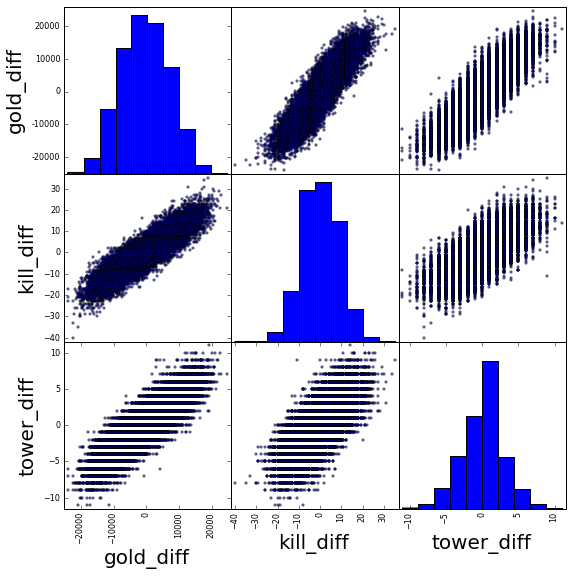

In [57]:
pd.tools.plotting.scatter_matrix(na_timelines_df[4][['gold_diff', 'kill_diff', 'tower_diff']], figsize = [9, 9]);

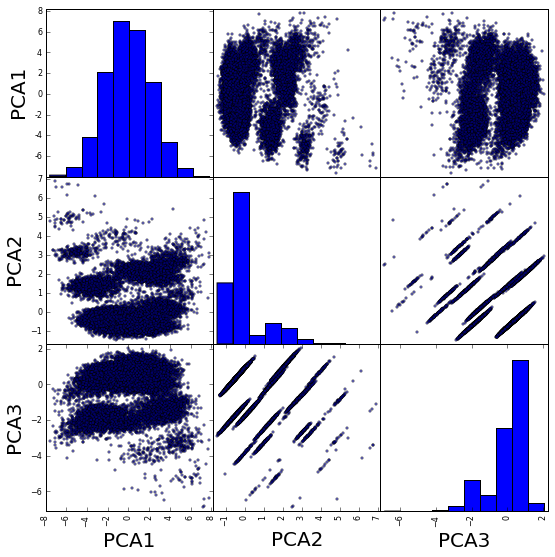

In [58]:
pd.tools.plotting.scatter_matrix(test_df[['PCA1', 'PCA2', 'PCA3']], figsize = [9, 9]);

In [73]:
na_pca_dfs = [pca_lol_df(x, pca_col) for x in na_timelines_df]
important_col_pca = ['PCA{0}'.format(x) for x in range(1,7)]
important_col_pca.extend(['first_baron', 'first_inhib'])

In [74]:
important_col_pca

['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'first_baron', 'first_inhib']

In [75]:
def cross_validate_pca(cur_df, feature_col):
    return cross_validation.cross_val_score(better_forest, cur_df[feature_col], cur_df['winner'], cv=3, n_jobs = 2)
pca_scores = [cross_validate_pca(x, important_col_pca) for x in na_pca_dfs]

In [76]:
unreduced_scores = [cross_validate_pca(x, important_col) for x in na_timelines_df]

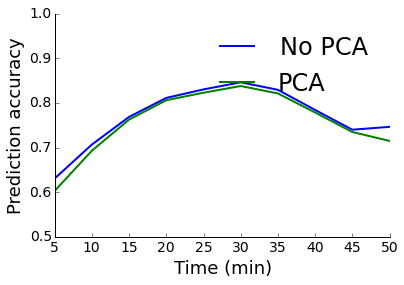

In [77]:
plt.plot(time_indices, np.mean(unreduced_scores, 1), label = 'No PCA')
plt.plot(time_indices, np.mean(pca_scores, 1), label = 'PCA')
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False);

## Does game get more predictable over time?

Now that we have features that are important, we can answer other questions.

In [93]:
def cross_validate_default(cur_df):
    return cross_validation.cross_val_score(default_forest, cur_df[default_col], cur_df['winner'], cv=3, n_jobs = 2)
def cross_validate_better(cur_df):
    return cross_validation.cross_val_score(better_forest, cur_df[better_col], cur_df['winner'], cv=3, n_jobs = 2)
default_scores = [cross_validate_default(x) for x in na_timelines_df]
better_scores = [cross_validate_better(x) for x in na_timelines_df]

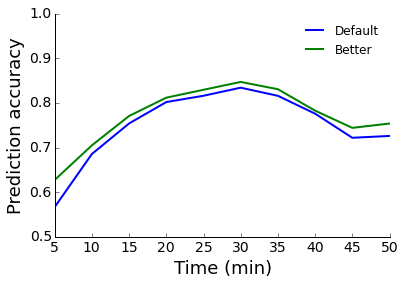

In [97]:
plt.plot(time_indices, np.mean(default_scores, 1), label = 'Default')
plt.plot(time_indices, np.mean(better_scores, 1), label = 'Better')
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False);

# Exploring hyper-parameters
## Model accuracy dependancy on samples

Make functions to run cross-validated models at each time point, then run THAT function using different sample size

In [98]:
rfc = RandomForestClassifier(n_jobs = 4, n_estimators = 25, max_features = 'sqrt', min_samples_leaf=10, min_samples_split=25)
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'], cv=5, n_jobs = 4)

def calc_score_per_samples(timelines_df, n_samples):
    timelines_scores = [cross_validate_df(x.sample(min(x.shape[0], n_samples)) ) for x in timelines_df]
    return np.mean(timelines_scores, 1)
sample_range = np.arange(1000, 20000, 3000)
scores_per_samples = [ calc_score_per_samples(na_timelines_df, x) for x in sample_range]

Now plot the model accuracy for different sample numbers.

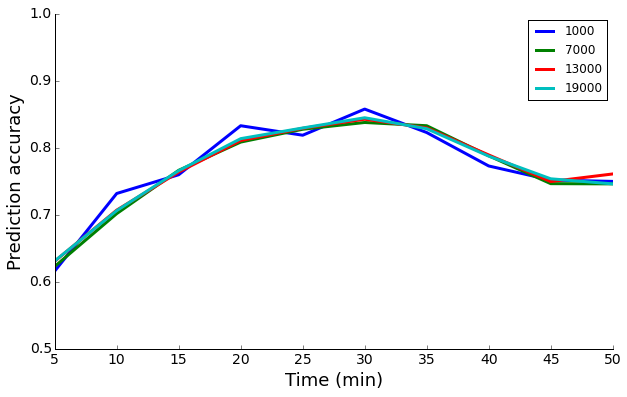

In [102]:
plt.figure(figsize = [10, 6])
for i, x in enumerate(scores_per_samples[::2]):
    plt.plot(time_indices, x, linewidth = 3, label = sample_range[2 * i])
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend();

The model improves from 1000 to 5000 samples, and a little more to 9000 samples, but beyond that it doesn't improve much

## Forest size versus prediction accuracy

How does increasing the forest size impact the accuracy of the model? We'll vary the forest size from 5 to 205

In [108]:
forest_sizes = [1,5,10, 25, 50]
cur_df = na_timelines_df[1]
def score_by_size(cur_size):
    size_forest = RandomForestClassifier(n_jobs = 4, n_estimators = cur_size, max_features = 'sqrt', min_samples_leaf=10, min_samples_split=25)
    return cross_validation.cross_val_score(size_forest, cur_df[important_col], cur_df['winner'], cv=4, n_jobs = 3)

size_scores = list(map(score_by_size, forest_sizes))

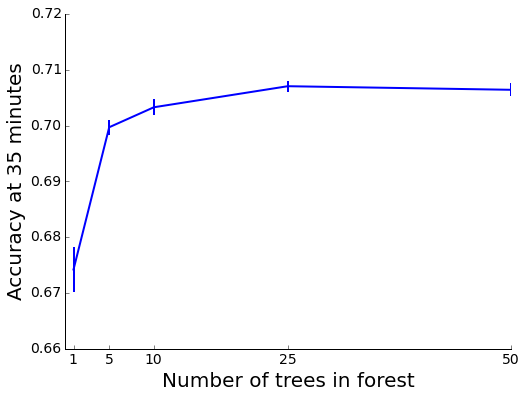

In [114]:
fig, ax = plt.subplots(1, figsize = [8, 6])
plt.errorbar(forest_sizes, np.mean(size_scores, 1), np.std(size_scores, 1) / np.sqrt(5), capsize = 0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 35 minutes')
plt.xlabel('Number of trees in forest')
ax.set_xticks(forest_sizes);
plt.ylim([0.66, 0.72]);

The accuracy increased noticeably from 5 to 25 forests, but not much from there.

## Grid search

In [71]:
from sklearn.grid_search import GridSearchCV
param_dict = { 'max_depth' : list(range(5, 16, 5)), 'min_samples_leaf': list(range(2,23,10)),
              'min_samples_split': list(range(10, 51, 10))}
grid_tree = GridSearchCV(RandomForestClassifier( n_estimators = 50, max_features = 'sqrt'),
                        param_grid = param_dict, cv = 3, n_jobs = 3)
grid_df = na_timelines_df[0]
grid_tree.fit(grid_df[important_col], grid_df['winner'])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'min_samples_split': [10, 20, 30, 40, 50], 'max_depth': [5, 10, 15], 'min_samples_leaf': [2, 12, 22]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [74]:
grid_tree.grid_scores_

[mean: 0.63139, std: 0.00255, params: {'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63178, std: 0.00279, params: {'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 2},
 mean: 0.63133, std: 0.00248, params: {'min_samples_split': 30, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63145, std: 0.00328, params: {'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 2},
 mean: 0.63133, std: 0.00367, params: {'min_samples_split': 50, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63139, std: 0.00362, params: {'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63125, std: 0.00334, params: {'min_samples_split': 20, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63167, std: 0.00437, params: {'min_samples_split': 30, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63122, std: 0.00336, params: {'min_samples_split': 40, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63186, std: 0.00314, params: {'min_samples_split': 

## Dependency on depth and min samples split:

In [21]:
def score_by_min_split(cur_min_split, cur_timelines):
    split_forest = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt', min_samples_split = cur_min_split)
    return cross_validation.cross_val_score(split_forest, cur_timelines[2][important_col],  cur_timelines[2]['winner'], cv=10, n_jobs = -1)

min_samples_array = list(range(1, 25, 5))
min_split_scores = list(map(lambda x: score_by_min_split(x, na_timelines_df), min_samples_array))

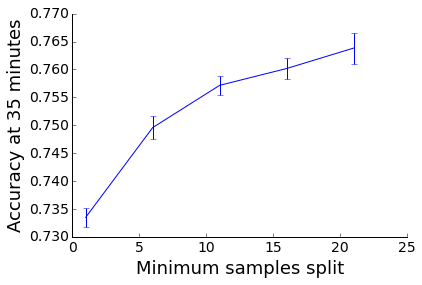

In [22]:
plt.errorbar(min_samples_array, np.mean(min_split_scores, 1), np.std(min_split_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 35 minutes', fontsize = 18)
plt.xlabel('Minimum samples split', fontsize = 18)
#plt.ylim([0.8, 0.85]);